# Example 3: Variational Bayesian Mixture of 1D Gaussians

In [1]:
import numpy as np
from scipy.special import digamma
import matplotlib.pyplot as plt

/home/wxdata/5/chrism/sw/anaconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def norm_pdf(x, mu, sigma2) :
    return (1./(np.sqrt(2.*np.pi*sigma2)))*np.exp((-1./2.*sigma2)*(x-mu)**2)

## Generate data from two independent Gaussians w/ the same variance

In [22]:
n1 = 100
mu1 = 4.0

n2 = 200
mu2 = -4.0

sigma2 = 0.25 # Constant Variance

np.random.seed(0)
X1 = np.random.normal(loc=mu1, scale=np.sqrt(sigma2), size=(n1,1))
X2 = np.random.normal(loc=mu2, scale=np.sqrt(sigma2), size=(n2,1))
N = n1 + n2
X = np.concatenate((X1,X2),axis=0)

<IPython.core.display.Javascript object>


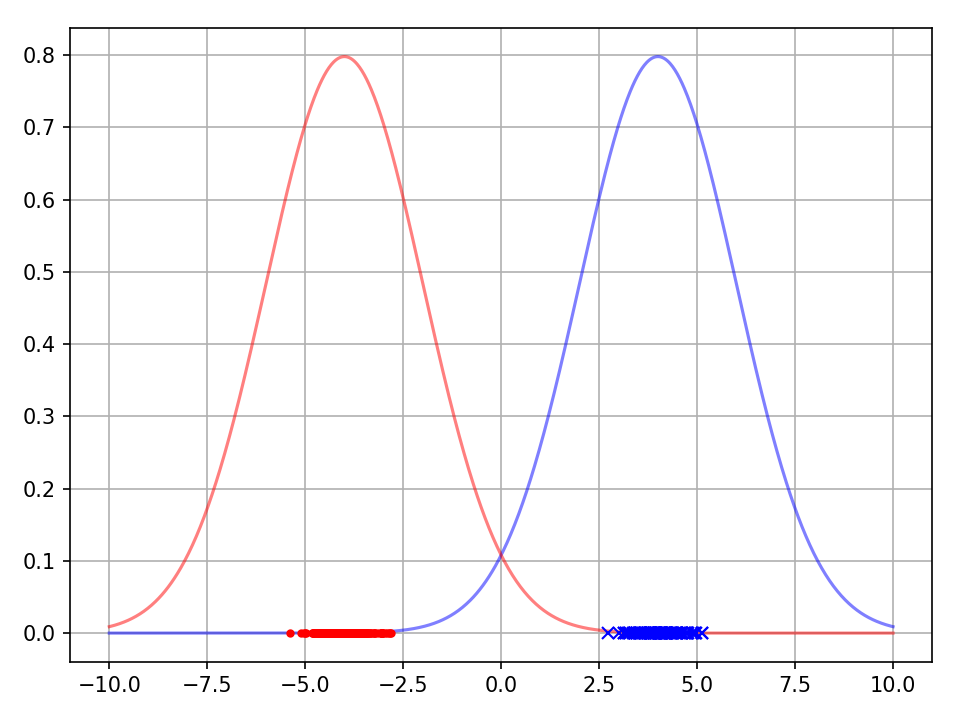

In [5]:
%matplotlib notebook
X_ = np.linspace(-10,10,1000)
plt.plot(X_, norm_pdf(X_,mu1,sigma2), 'b', alpha=0.5)
plt.plot(X_, norm_pdf(X_,mu2,sigma2), 'r', alpha=0.5)
plt.plot(X1, np.zeros_like(X1), 'bx')
plt.plot(X2, np.zeros_like(X2), 'r.')


plt.grid()
plt.tight_layout()
plt.show()

## Make Initial Selections of Parameters

In [21]:
K = 6

# pi~Dir(alpha)
alpha = np.zeros((K,1)) + N/K

# mu~N(m,lamb)
lamb_0 = 10.0
lamb = lamb_0*np.ones((K,1))
m = np.random.multivariate_normal(np.zeros(K,),lamb_0*np.eye(K))[:,np.newaxis]

## Find optimal solution

In [23]:
MAX_ITERS = 1
collected_alpha = alpha.copy()
collected_m = m.copy()
collected_lamb = lamb.copy()

for i in range(0,MAX_ITERS) :
    # Calculate E[Z] = R, update R
    log_Rho = -0.5*(1/sigma2)*(X**2).dot(np.ones((1,K)))
    log_Rho += (1/sigma2)*X.dot(m.transpose())
    log_Rho -= np.squeeze(0.5*(1/sigma2)*(lamb+m**2))
    log_Rho += np.squeeze(digamma(alpha) - digamma(np.sum(alpha)))
    log_Rho -= 0.5*np.log(2*np.pi*sigma2)
    Rho = np.exp(log_Rho)
    R = Rho/np.sum(Rho,axis=1)[:,np.newaxis]
    
    # Q*(pi) using R, update alpha
    alpha = alpha + np.sum(R,axis=0)[:,np.newaxis]
    collected_alpha = np.hstack((collected_alpha,alpha))
    
    # Q*(mu), update m, lamb
    m = (lamb*np.sum(R*X,axis=0)[:,np.newaxis]+sigma2*m)/(lamb*np.sum(R,axis=0)[:,np.newaxis]+sigma2)
    lamb = (lamb*sigma2)/(lamb*np.sum(R,axis=0)[:,np.newaxis]+sigma2)
    collected_m = np.hstack((collected_m, m))
    collected_lamb = np.hstack((collected_lamb, lamb))

## Plot Results

<IPython.core.display.Javascript object>


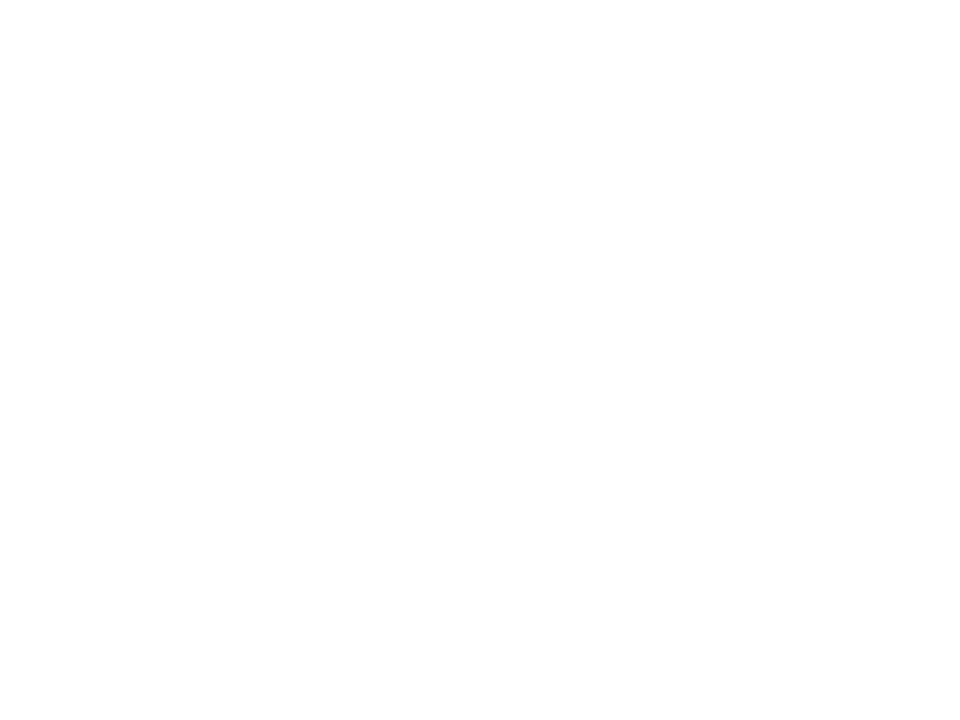

IndexError: index 20 is out of bounds for axis 1 with size 11

In [16]:
%matplotlib notebook
iterations = [0, 1, 20, 100]
fig = plt.figure()

for j,itera in enumerate(iterations) :
    ax = fig.add_subplot(2,2,j+1)
    ax.plot(X, np.zeros_like(X), 'kx')
    for i in range(0,K) :
        std = np.sqrt(collected_lamb[i,itera])
        ax.axvline(x=collected_m[i,itera],color='g')
        ax.axvspan(collected_m[i,itera]-std, collected_m[i,itera]+std, alpha=0.25, color='g')

    ax.plot(mu1, 0, 'b.', ms=30, alpha=0.5)
    ax.plot(mu2, 0, 'r.', ms=30, alpha=0.5)
    ax.set_title('Iter # ' + str(itera))
    ax.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

In [12]:
print('Means {}'.format(m))
print('Pis {}'.format(alpha/np.sum(alpha)))

Means [[-4.06562314]
 [ 4.13617552]
 [-0.38022887]
 [-3.6790068 ]
 [ 3.80638795]
 [-3.73606341]]
Pis [[5.35634615e-01]
 [2.25859881e-01]
 [1.66500382e-04]
 [7.86865552e-02]
 [1.07473452e-01]
 [5.21789965e-02]]


<IPython.core.display.Javascript object>


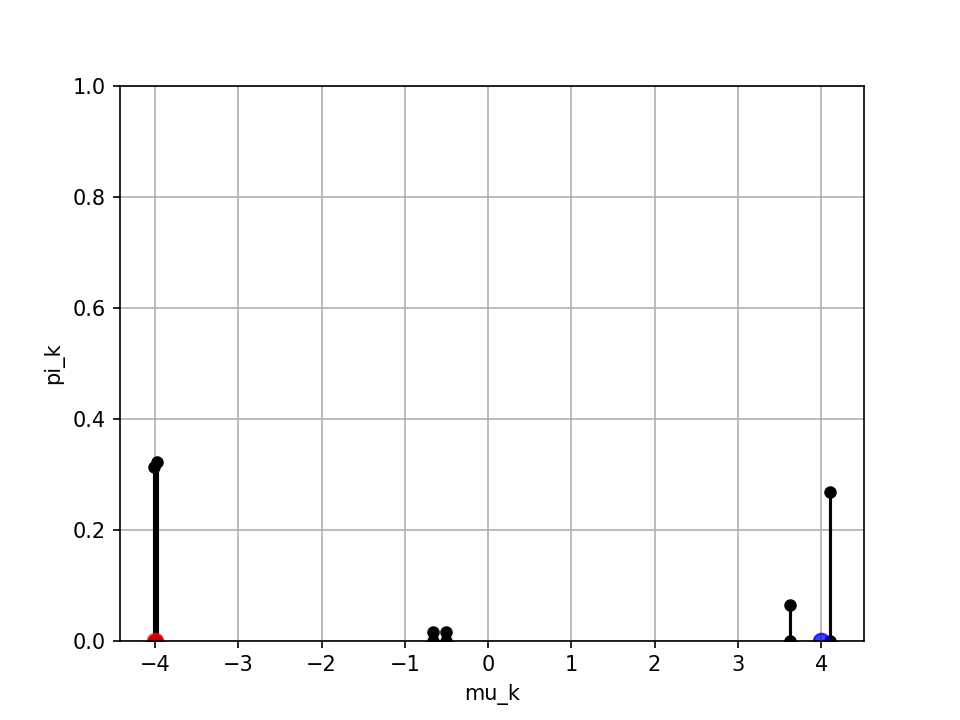

In [17]:
%matplotlib notebook
mixing = alpha/np.sum(alpha)
for i,mm in enumerate(m) :
    plt.axvline(x=mm,ymax=mixing[i], color='k', marker='.', ms=10)
plt.plot(mu1, 0, 'b.', ms=15, alpha=0.75)
plt.plot(mu2, 0, 'r.', ms=15, alpha=0.75)
plt.ylim(0,1)
plt.grid()
plt.xlabel('mu_k')
plt.ylabel('pi_k')
plt.show()

## Posterior Predictive Distribution

In [18]:
def ppd(xn,X,R,m,lamb,alpha,sigma2) :
    K = m.shape[0]
    pxn = np.zeros_like(xn)
    m_hat = (sigma2*m + lamb*np.sum(R*X,axis=0)[:,np.newaxis])/(sigma2 + lamb*np.sum(R,axis=0)[:,np.newaxis])
    lamb_hat = (lamb*sigma2)/(sigma2 + lamb*np.sum(R,axis=0)[:,np.newaxis])
    for k in range(0,K) :
        pxn += alpha[k,0]*norm_pdf(xn,m[k,0],lamb[k,0]+sigma2)
    return (1/np.sum(alpha))*pxn

In [19]:
def true_ppd(xn,X,mu1,mu2,lamb,sigma2) :
    N = X.shape[0]
    m1 = (mu1*sigma2 + lamb*np.sum(X))/(N*lamb + sigma2)
    m2 = (mu2*sigma2 + lamb*np.sum(X))/(N*lamb + sigma2)
    s = sigma2+(sigma2*lamb/(N*lamb + sigma2))
    return (1/3)*norm_pdf(X_,m1,s)+(2/3)*norm_pdf(X_,m2,s)

<IPython.core.display.Javascript object>


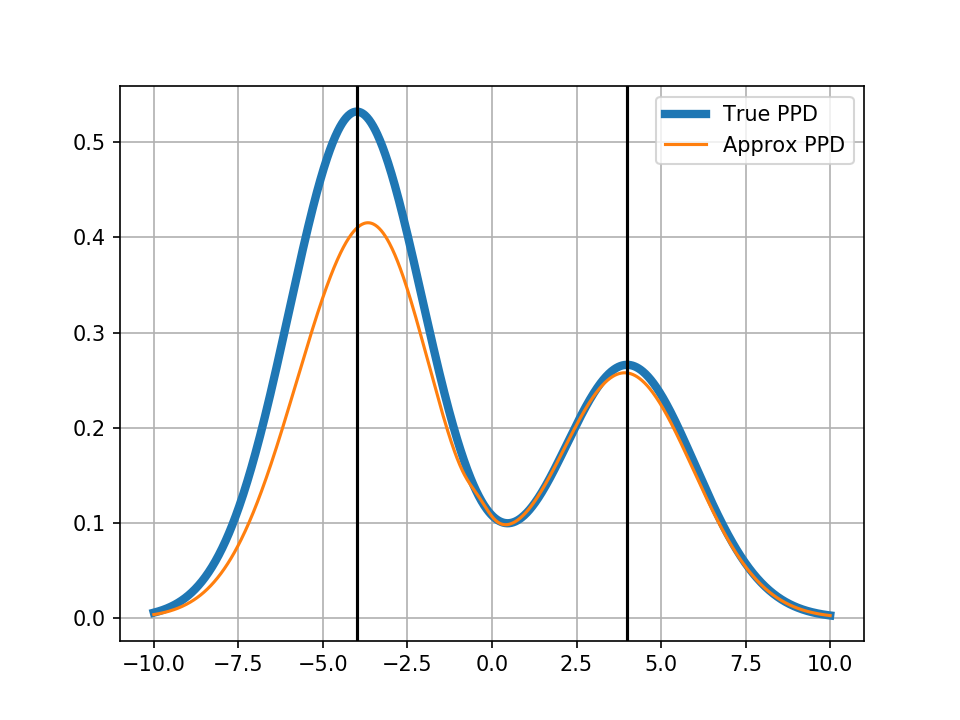

In [24]:
%matplotlib notebook
X_ = np.linspace(-10,10,1000)
plt.plot(X_,true_ppd(X_,X,mu1,mu2,0,sigma2), lw=4)
plt.plot(X_,ppd(X_,X,R,m,lamb,alpha,sigma2))
plt.axvline(x=mu1, color='k')
plt.axvline(x=mu2, color='k')
plt.legend(['True PPD', 'Approx PPD'])
plt.grid()
plt.show()